In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Pfade
BASE = Path.cwd().parent
RAW  = BASE / "data" / "raw" / "brazilian-ecommerce"
PROC = BASE / "data" / "processed"

# Fact
fact = pd.read_parquet(PROC / "fact_order_items.parquet")

# Orders (für Lieferzeiten)
orders = pd.read_csv(
    RAW / "olist_orders_dataset.csv",
    parse_dates=[
        "order_purchase_timestamp",
        "order_approved_at",
        "order_delivered_carrier_date",
        "order_delivered_customer_date",
        "order_estimated_delivery_date",
    ],
)
# Reviews
reviews = pd.read_csv(RAW / "olist_order_reviews_dataset.csv")

# Lieferzeit-Features
orders["delivery_time_days"] = (orders["order_delivered_customer_date"] - orders["order_purchase_timestamp"]).dt.days
orders["expected_time_days"] = (orders["order_estimated_delivery_date"] - orders["order_purchase_timestamp"]).dt.days
orders["delay_vs_expected"]  = orders["delivery_time_days"] - orders["expected_time_days"]

# nur gelieferte Bestellungen
orders_valid = orders[orders["order_status"] == "delivered"].copy()

print("fact:", fact.shape, "orders_valid:", orders_valid.shape, "reviews:", reviews.shape)


fact: (112101, 19) orders_valid: (96478, 11) reviews: (99224, 7)


In [29]:
# je Order genau ein Seller? -> aus fact ableiten
order_seller = fact[["order_id","seller_id"]].drop_duplicates()

seller_perf = (
    orders_valid[["order_id","delivery_time_days","expected_time_days","delay_vs_expected"]]
    .merge(order_seller, on="order_id", how="left")
    .merge(reviews[["order_id","review_score"]], on="order_id", how="left")
)

seller_perf.head()


,order_id,delivery_time_days,expected_time_days,delay_vs_expected,seller_id,review_score
0,e481f51cbdc54678b7cc49136f2d6af7,8.0,15,-7.0,3504c0cb71d7fa48d967e0e4c94d59d9,4.0
1,53cdb2fc8bc7dce0b6741e2150273451,13.0,19,-6.0,289cdb325fb7e7f891c38608bf9e0962,4.0
2,47770eb9100c2d0c44946d9cf07ec65d,9.0,26,-17.0,4869f7a5dfa277a7dca6462dcf3b52b2,5.0
3,949d5b44dbf5de918fe9c16f97b45f8a,13.0,26,-13.0,66922902710d126a0e7d26b0e3805106,5.0
4,ad21c59c0840e6cb83a9ceb5573f8159,2.0,12,-10.0,2c9e548be18521d1c43cde1c582c6de8,5.0


In [30]:
seller_stats = (
    seller_perf.groupby("seller_id")
    .agg(
        orders=("order_id","nunique"),
        avg_delivery_days=("delivery_time_days","mean"),
        late_share=("delay_vs_expected", lambda s: np.mean(s > 0)),
        extreme_late_share=("delay_vs_expected", lambda s: np.mean(s > 5)),  # >5 Tage zu spät
        avg_review=("review_score","mean"),
        bad_review_share=("review_score", lambda s: np.mean(s <= 2)),
    )
    .reset_index()
)

# Umsätze dazu (aus fact)
seller_revenue = (
    fact.groupby("seller_id")
        .agg(gmv_brl=("item_revenue_brl","sum"),
             items=("order_item_id","count"))
        .reset_index()
)

seller_stats = seller_stats.merge(seller_revenue, on="seller_id", how="left")

# nur Seller mit genügend Daten (z.B. > 50 Bestellungen)
seller_stats = seller_stats[seller_stats["orders"] > 50].copy()
seller_stats.describe()


,orders,avg_delivery_days,late_share,extreme_late_share,avg_review,bad_review_share,gmv_brl,items
count,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000,413.000000
mean,177.675545,11.928133,0.071515,0.039182,4.148150,0.130601,21912.101913,202.254237
std,234.331421,2.889591,0.045645,0.030932,0.289869,0.069385,31983.559705,270.809512
min,51.000000,4.636364,0.000000,0.000000,2.392523,0.011494,1425.200000,53.000000
25%,69.000000,9.808824,0.037736,0.017544,4.000000,0.088235,6643.090000,80.000000
50%,101.000000,11.730769,0.061630,0.032787,4.183333,0.118644,11389.100000,116.000000
75%,172.000000,13.612903,0.099003,0.052830,4.336842,0.160714,22490.600000,196.000000
max,1819.000000,26.193548,0.301370,0.273973,4.818182,0.592593,229237.630000,2025.000000


171 Seller machen 80% des Umsatzes aus. (50%: 51, 95%: 311)


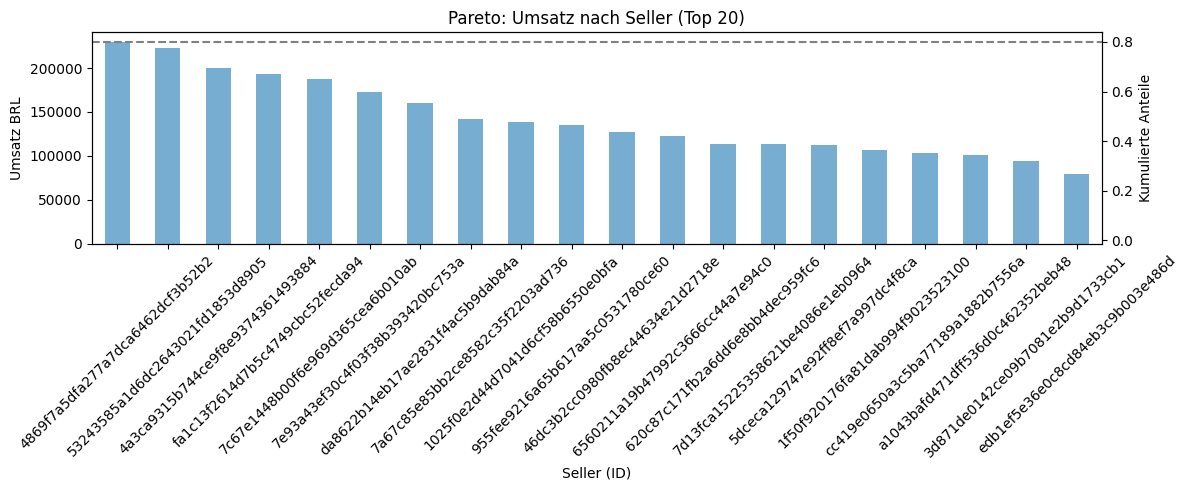

In [31]:
seller_rev_sorted = seller_stats.sort_values("gmv_brl", ascending=False)[["seller_id","gmv_brl"]]
cum_share = seller_rev_sorted["gmv_brl"].cumsum() / seller_rev_sorted["gmv_brl"].sum()

top_50  = (cum_share <= 0.50).sum()
top_80  = (cum_share <= 0.80).sum()
top_95  = (cum_share <= 0.95).sum()
print(f"{top_80} Seller machen 80% des Umsatzes aus. (50%: {top_50}, 95%: {top_95})")

# Plot Top 20 für Lesbarkeit
top_n = 20
fig, ax1 = plt.subplots(figsize=(12,5))
seller_rev_sorted.head(top_n).set_index("seller_id")["gmv_brl"].plot(kind="bar", ax=ax1, alpha=0.6)
ax1.set_xlabel("Seller (ID)")
ax1.set_ylabel("Umsatz BRL")
ax1.tick_params(axis="x", rotation=45)
ax2 = ax1.twinx()
cum_share.head(top_n).plot(ax=ax2, color="r", linewidth=2)
ax2.set_ylabel("Kumulierte Anteile")
ax2.axhline(0.8, color="gray", linestyle="--")
plt.title("Pareto: Umsatz nach Seller (Top 20)")
plt.tight_layout(); plt.show()


In [32]:
problem_sellers = (
    seller_stats
    .sort_values(["extreme_late_share","late_share","bad_review_share"], ascending=False)
    .loc[:, ["seller_id","orders","gmv_brl","avg_delivery_days","late_share","extreme_late_share","avg_review","bad_review_share"]]
    .head(20)
)

print("Top 20 Problem-Seller (viel zu spät & schlechte Reviews)")
problem_sellers


Top 20 Problem-Seller (viel zu spät & schlechte Reviews)


,seller_id,orders,gmv_brl,avg_delivery_days,late_share,extreme_late_share,avg_review,bad_review_share
1000,54965bbe3e4f07ae045b90b0b8541f52,73,10961.30,25.657534,0.301370,0.273973,3.144928,0.383562
1336,712e6ed8aa4aa1fa65dab41fed5737e4,77,39815.00,24.217949,0.217949,0.179487,3.402597,0.346154
2211,beadbee30901a7f61d031b6b686095ad,64,4373.98,13.609375,0.250000,0.156250,3.906250,0.187500
1928,a49928bcdf77c55c6d6e05e09a9b4ca5,96,8816.70,16.510417,0.229167,0.135417,3.031250,0.406250
79,06a2c3af7b3aee5d69171b0e14f0ee87,389,36408.95,17.269231,0.207692,0.123077,4.015544,0.158974
1606,88460e8ebdecbfecb5f9601833981930,246,31396.65,17.432540,0.182540,0.123016,3.450199,0.301587
2365,cac4c8e7b1ca6252d8f20b2fc1a2e4af,74,4168.18,17.813333,0.226667,0.120000,3.567568,0.280000
2657,e5a3438891c0bfdb9394643f95273d8e,216,7711.05,15.362385,0.174312,0.119266,3.976959,0.178899
203,11bfa66332777660bd0640ee84d47006,76,3925.87,16.194805,0.155844,0.116883,3.883117,0.233766
2448,d20b021d3efdf267a402c402a48ea64b,86,4060.18,16.471264,0.172414,0.114943,3.767442,0.195402


In [33]:
top_quality = (
    seller_stats
    .sort_values(["late_share","bad_review_share","avg_delivery_days"], ascending=[True, True, True])
    .loc[:, ["seller_id","orders","gmv_brl","avg_delivery_days","late_share","avg_review","bad_review_share"]]
    .head(20)
)

print("Top 20 Seller-Qualität (pünktlich & gute Reviews)")
top_quality


Top 20 Seller-Qualität (pünktlich & gute Reviews)


,seller_id,orders,gmv_brl,avg_delivery_days,late_share,avg_review,bad_review_share
614,3504c0cb71d7fa48d967e0e4c94d59d9,53,2349.94,6.943396,0.000000,4.415094,0.037736
1041,57e632711dec9ec14ca7546769483e7e,62,6350.06,10.396825,0.000000,4.396825,0.047619
2691,e882b2a25a10b9c057cc49695f222c19,57,51057.54,9.050847,0.000000,4.593220,0.050847
1767,9616352088dcf83a7c06637f4ebf1c80,91,5703.00,11.923913,0.000000,4.336957,0.076087
496,2b3e4a2a3ea8e01938cabda2a3e5cc79,52,23629.15,8.211538,0.000000,4.365385,0.076923
2390,cc63f0dd2acba93ffed4fe9f8e0321fa,55,7096.71,8.527273,0.000000,4.090909,0.090909
2072,b372ee768ed69e46ca8cdbd267aa7a38,63,12630.00,12.140625,0.000000,4.437500,0.093750
2924,fc906263ca5083d09dce42fe02247800,112,4497.70,8.964602,0.000000,4.380531,0.097345
2832,f3b80352b986ab4d1057a4b724be19d0,86,10505.10,9.941860,0.000000,4.209302,0.116279
2902,fa1a9dec3a9940c072684a46728bf1fc,55,6674.00,13.800000,0.000000,4.111111,0.127273


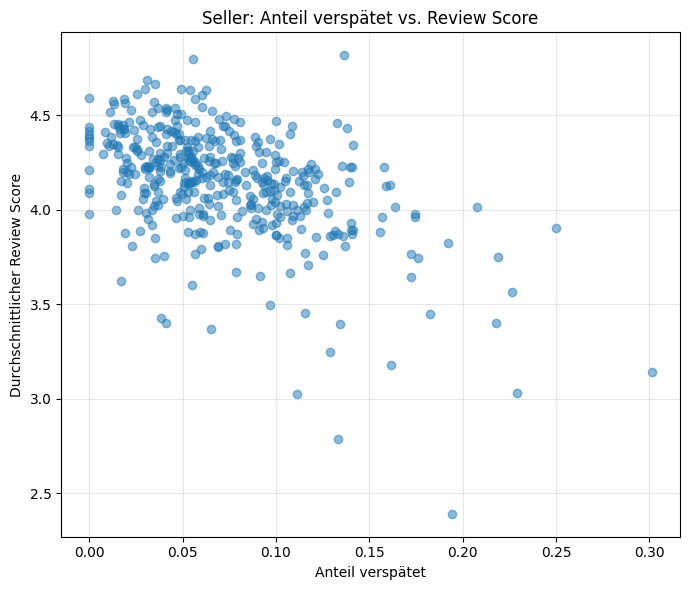

In [34]:
plt.figure(figsize=(7,6))
plt.scatter(seller_stats["late_share"], seller_stats["avg_review"], alpha=0.5)
plt.xlabel("Anteil verspätet")
plt.ylabel("Durchschnittlicher Review Score")
plt.title("Seller: Anteil verspätet vs. Review Score")
plt.grid(True, alpha=0.3)
plt.tight_layout(); plt.show()


In [35]:
# z.B. Kandidaten für SLA/Intervention
sla_candidates = seller_stats[
    (seller_stats["orders"] >= 100) &
    (seller_stats["late_share"] > 0.30) &
    (seller_stats["bad_review_share"] > 0.15)
].sort_values(["late_share","bad_review_share"], ascending=False)

print("SLA-Kandidaten (Beispielschwellen)")
sla_candidates.head(20)


SLA-Kandidaten (Beispielschwellen)


,seller_id,orders,avg_delivery_days,late_share,extreme_late_share,avg_review,bad_review_share,gmv_brl,items


,seller_id,total_revenue,total_freight,orders,items,avg_review
0,0015a82c2db000af6aaaf3ae2ecb0532,2685.00,63.06,3,3,3.666667
1,001cca7ae9ae17fb1caed9dfb1094831,25080.03,8854.14,200,239,3.984772
2,001e6ad469a905060d959994f1b41e4f,250.00,17.94,1,1,1.000000
3,002100f778ceb8431b7a1020ff7ab48f,1234.50,793.66,51,55,3.901961
4,003554e2dce176b5555353e4f3555ac8,120.00,19.38,1,1,5.000000


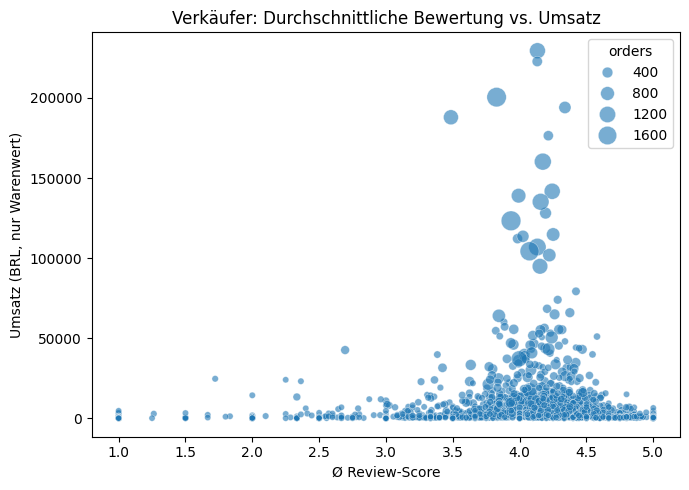

In [36]:
import pandas as pd
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt

BASE = Path.cwd().parent        # wenn Notebook in /notebooks liegt
RAW  = BASE / "data" / "raw" / "brazilian-ecommerce"

# 1) Order-Items: Umsätze pro Seller
oi = pd.read_csv(
    RAW / "olist_order_items_dataset.csv",
    usecols=["order_id","seller_id","price","freight_value"]
)

seller_sales = (
    oi.groupby("seller_id")
      .agg(
          total_revenue=("price","sum"),         # Umsatz (nur Warenwert)
          total_freight=("freight_value","sum"), # Versandkosten
          orders=("order_id","nunique"),
          items=("order_id","size")
      )
      .reset_index()
)

# 2) Reviews: durchschnittlicher Review-Score pro Seller
reviews = pd.read_csv(
    RAW / "olist_order_reviews_dataset.csv",
    usecols=["order_id","review_score"]
)
rev_per_order = reviews.groupby("order_id", as_index=False)["review_score"].mean()

# Seller ↔ Order (dedupliziert) und dann Reviews mappen
seller_order = oi[["order_id","seller_id"]].drop_duplicates()
seller_rev = (
    seller_order
    .merge(rev_per_order, on="order_id", how="left")
    .groupby("seller_id", as_index=False)["review_score"].mean()
    .rename(columns={"review_score":"avg_review"})
)

# 3) Zusammenführen
seller_stats = seller_sales.merge(seller_rev, on="seller_id", how="left")

display(seller_stats.head())

# 4) Scatter: Bewertung vs. Umsatz
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=seller_stats, x="avg_review", y="total_revenue",
    size="orders", sizes=(20,200), alpha=0.6
)
plt.title("Verkäufer: Durchschnittliche Bewertung vs. Umsatz")
plt.xlabel("Ø Review-Score")
plt.ylabel("Umsatz (BRL, nur Warenwert)")
plt.tight_layout()
plt.show()
